# Normal EML Method

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import copy as cp
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#!pip install pyswarms   #in case Pyswarms is not installed
import pyswarms as ps


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#train_x = pd.read_csv('electricity-related factors.csv',header=None)
train_x = pd.read_csv('/content/drive/My Drive/semIII/modeling/marketing/Evolutionary-Multivariate-Electricity-Consumption-Prediction-master/data/electricity-related factors.csv',header=None)

In [0]:
train_y = pd.read_csv('/content/drive/My Drive/semIII/modeling/marketing/Evolutionary-Multivariate-Electricity-Consumption-Prediction-master/data/historical electricity.csv',header=None)
#train_y = pd.read_csv('historical electricity.csv',header=None)

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(train_x)
train_x = pd.DataFrame(sc.fit_transform(train_x))
sc.fit(train_y)
train_y = pd.DataFrame(sc.fit_transform(train_y))

In [0]:
train_x.head()

,0,1,2
0,-0.766569,-0.310808,-0.649521
1,-0.843670,-0.350926,-0.700112
2,-0.978285,-0.779489,0.386462
3,-1.004372,-0.799229,0.400620
4,-0.951870,-0.820753,0.541489


In [0]:
print(train_x.shape)
print(train_y.shape)

(9600, 3)
(35040, 1)


In [0]:
train_x =np.array(train_x)
train_y = np.array(train_y[:9600])
train_y.shape
train_y.flatten()

array([-0.81574153, -0.84709983, -0.87350683, ..., -0.81971377,
       -0.84128134, -0.85652691])

In [0]:
data = pd.DataFrame(train_x)
data.insert(loc=3,column='3',value=train_y)
data.head()

,0,1,2,3
0,-0.766569,-0.310808,-0.649521,-0.815742
1,-0.843670,-0.350926,-0.700112,-0.847100
2,-0.978285,-0.779489,0.386462,-0.873507
3,-1.004372,-0.799229,0.400620,-0.883633
4,-0.951870,-0.820753,0.541489,-0.859156


In [0]:
data = np.array(data)

In [0]:
# ELM Class

class Network(object):

    def __init__(self, input_dim, hidden_dim=10, output_dim=1):
        '''
        Neural Network object 
        '''
        self.N = input_dim
        self.M = hidden_dim
        self.O = output_dim
        
        self.W1 = np.matrix(np.random.rand(self.N, self.M))
        self.W2 = np.matrix(np.random.rand(self.M, self.O))
        
        self.U = 0
        self.V = 0
        self.S = 0
        self.H = 0
        self.alpha = 0 # for regularization
        
    # Helper function
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-0.1 * x)) - 0.5
    
    def predict(self, x):
        '''
        Forward pass to calculate the ouput
        '''
        x = np.matrix(x)
        y = self.sigmoid(x @ self.W1) @ self.W2
        return y
    
    def train(self, x, y):
        '''
        Compute W2 that lead to minimal LS
        '''
        X = np.matrix(x)
        Y = np.matrix(y)
        self.H = np.matrix(self.sigmoid(X @ self.W1))
        H = cp.deepcopy(self.H)
        
        self.svd(H)
        iH = np.matrix(self.V) @ np.matrix(np.diag(self.S)).I @ np.matrix(self.U).T

        self.W2 = iH * Y
        print('W2 values updated..')
        return H @ self.W2 - Y
    
    def svd(self, h):
        '''
        Compute the Singular Value Decomposition of a matrix H
        '''
        H = np.matrix(h)
        self.U, self.S, Vt = np.linalg.svd(H, full_matrices=False)
        self.V = np.matrix(Vt).T
        print('SVD computed.. calculating Pseudoinverse..')
        return np.matrix(self.U), np.matrix(self.S), np.matrix(self.V)

In [0]:
#subsetting Data into Train and test set

X_train = train_x[:7200]
Y_train = train_y[:7200]
X_test = train_x[7200:len(train_x)]
Y_test = train_y[7200:len(train_y)]
print(X_train.shape,'\n',Y_train.shape)

(7200, 3) 
 (7200, 1)


In [0]:
neurons = []
tr_rmse = []
te_rmse = []
tr_mae  = []
te_mae  = []
tr_r2 = []
te_r2 = []
for i in range(1,25):
    neuron = i*5
    NN = Network(input_dim=3, hidden_dim=neuron, output_dim=1)
    eml_residuals = NN.train(X_train,Y_train)

    fit1 = NN.predict(X_train)
    fit2 = NN.predict(X_test)
    #predictions = NN.predict(test_windows.iloc[:,:-1])

    eml_fit1 = cp.deepcopy(fit1)
    eml_fit2 = cp.deepcopy(fit2)
    neurons.append(neuron)
    tr_rmse.append(mean_squared_error(eml_fit1,Y_train))
    te_rmse.append(mean_squared_error(eml_fit2,Y_test))
    tr_mae.append(mean_absolute_error(eml_fit1,Y_train))
    te_mae.append(mean_absolute_error(eml_fit2,Y_test))
    tr_r2.append(r2_score(eml_fit1, Y_train))
    te_r2.append(r2_score(eml_fit2, Y_test))
    print(neuron)

SVD computed.. calculating Pseudoinverse..
W2 values updated..
5
SVD computed.. calculating Pseudoinverse..
W2 values updated..
10
SVD computed.. calculating Pseudoinverse..
W2 values updated..
15
SVD computed.. calculating Pseudoinverse..
W2 values updated..
20
SVD computed.. calculating Pseudoinverse..
W2 values updated..
25
SVD computed.. calculating Pseudoinverse..
W2 values updated..
30
SVD computed.. calculating Pseudoinverse..
W2 values updated..
35
SVD computed.. calculating Pseudoinverse..
W2 values updated..
40
SVD computed.. calculating Pseudoinverse..
W2 values updated..
45
SVD computed.. calculating Pseudoinverse..
W2 values updated..
50
SVD computed.. calculating Pseudoinverse..
W2 values updated..
55
SVD computed.. calculating Pseudoinverse..
W2 values updated..
60
SVD computed.. calculating Pseudoinverse..
W2 values updated..
65
SVD computed.. calculating Pseudoinverse..
W2 values updated..
70
SVD computed.. calculating Pseudoinverse..
W2 values updated..
75
SVD compute

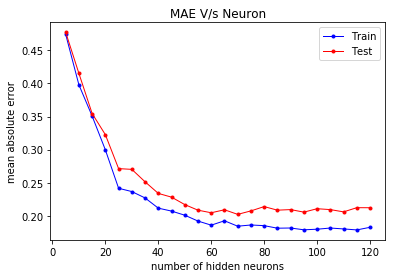

In [0]:
plt.plot(neurons, tr_mae, marker='.', color='blue', label="Train", linewidth=1.0)
plt.plot(neurons, te_mae, marker='.', color='red', label="Test", linewidth=1.0)
plt.legend()
plt.xlabel('number of hidden neurons')
plt.ylabel('mean absolute error')
plt.title('MAE V/s Neuron')
plt.show()

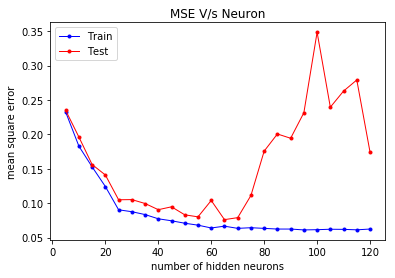

In [0]:
plt.plot(neurons, tr_rmse, marker='.', color='blue', label="Train", linewidth=1.0)
plt.plot(neurons, te_rmse, marker='.', color='red', label="Test", linewidth=1.0)
plt.legend()
plt.xlabel('number of hidden neurons')
plt.ylabel('mean square error')
plt.title('MSE V/s Neuron')
plt.show()

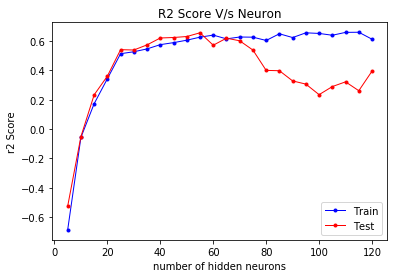

In [0]:
plt.plot(neurons, tr_r2, marker='.', color='blue', label="Train", linewidth=1.0)
plt.plot(neurons, te_r2, marker='.', color='red', label="Test", linewidth=1.0)
plt.legend()
plt.xlabel('number of hidden neurons')
plt.ylabel('r2 Score')
plt.title('R2 Score V/s Neuron')
plt.show()

In [0]:
NN = Network(input_dim=3, hidden_dim=50, output_dim=1)
eml_residuals = NN.train(X_train,Y_train)
fit1 = NN.predict(X_train)
fit2 = NN.predict(X_test)
eml_fit1 = cp.deepcopy(fit1)
eml_fit2 = cp.deepcopy(fit2)

print('Train MAE = ',mean_absolute_error(eml_fit1,Y_train),'\n Test MAE',mean_absolute_error(eml_fit2,Y_test))
print('Train MSE = ',mean_squared_error(eml_fit1,Y_train),'\n Test MSE',mean_squared_error(eml_fit2,Y_test))
print('Train r2 = ',r2_score(eml_fit1,Y_train),'\n Test R2',r2_score(eml_fit2,Y_test))


SVD computed.. calculating Pseudoinverse..
W2 values updated..
Train MAE =  0.20124846903692004 
 Test MAE 0.2219145362604746
Train MSE =  0.07176879094914256 
 Test MSE 0.08818834540797077
Train r2 =  0.6014476853326141 
 Test R2 0.6364662348048952


# apply PSO

In [0]:
w1 = cp.deepcopy(NN.W1)
w2 = cp.deepcopy(NN.W2)

In [0]:
def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-0.1 * x)) - 0.5

In [0]:

def loss(param):
  pred = sigmoid(X_train@w1)@param
  Loss = np.sqrt(np.sum((np.power((pred - Y_train),2))))/len(pred)
  return Loss

In [0]:
def f(x):
    n_particles = x.shape[0]
    print(x.shape)
    j = [loss(x[i]) for i in range(n_particles)]
    return np.array(j)

In [0]:
%%time
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
dimensions = (50 * 1)
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=10)
print(cost,pos)

2019-08-18 11:26:55,206 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}














pyswarms.single.global_best:   0%|          |0/10

(10, 50)
















pyswarms.single.global_best:   0%|          |0/10, best_cost=5.18e+3













pyswarms.single.global_best:  10%|█         |1/10, best_cost=5.18e+3

(10, 50)
















pyswarms.single.global_best:  10%|█         |1/10, best_cost=5.18e+3













pyswarms.single.global_best:  20%|██        |2/10, best_cost=5.18e+3

(10, 50)
















pyswarms.single.global_best:  20%|██        |2/10, best_cost=5.18e+3













pyswarms.single.global_best:  30%|███       |3/10, best_cost=5.18e+3

(10, 50)
















pyswarms.single.global_best:  30%|███       |3/10, best_cost=5.18e+3













pyswarms.single.global_best:  40%|████      |4/10, best_cost=5.18e+3

(10, 50)
















pyswarms.single.global_best:  40%|████      |4/10, best_cost=5.18e+3













pyswarms.single.global_best:  50%|█████     |5/10, best_cost=5.18e+3

(10, 50)
















pyswarms.single.global_best:  50%|█████     |5/10, best_cost=4.79e+3













pyswarms.single.global_best:  60%|██████    |6/10, best_cost=4.79e+3

(10, 50)
















pyswarms.single.global_best:  60%|██████    |6/10, best_cost=4.38e+3













pyswarms.single.global_best:  70%|███████   |7/10, best_cost=4.38e+3

(10, 50)
















pyswarms.single.global_best:  70%|███████   |7/10, best_cost=4.38e+3













pyswarms.single.global_best:  80%|████████  |8/10, best_cost=4.38e+3

(10, 50)
















pyswarms.single.global_best:  80%|████████  |8/10, best_cost=4.38e+3













pyswarms.single.global_best:  90%|█████████ |9/10, best_cost=4.38e+3

(10, 50)
















pyswarms.single.global_best:  90%|█████████ |9/10, best_cost=4.38e+3













pyswarms.single.global_best: 100%|██████████|10/10, best_cost=4.38e+3













2019-08-18 11:28:04,857 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4384.085429142764, best pos: [-1.01042176  0.39589572  0.28289931  0.45635794  0.1845113  -0.25685771
 -0.13165179 -0.77434326  0.02403827 -0.29303648 -0.05362545 -0.0686187
  0.44839932 -0.01412898  0.47711333  0.26568292 -0.43739088  0.38950405
  0.00415889 -0.09347538  0.40981028 -0.58514155  0.38912523 -0.39825546
  0.05706221  0.13034347  0.79555198  0.0910253  -0.31886967  0.40441009
 -0.00807209 -0.01700101  0.13926087  0.04111175 -0.43939321 -0.08801831
  0.663147   -0.51503075  0.11290423  0.36216295  0.00931375  0.0809528
  0.24042982 -0.22651107 -0.1469847  -0.0484282  -0.5542631   0.37556603
  0.11256003  0.15339964]


4384.085429142764 [-1.01042176  0.39589572  0.28289931  0.45635794  0.1845113  -0.25685771
 -0.13165179 -0.77434326  0.02403827 -0.29303648 -0.05362545 -0.0686187
  0.44839932 -0.01412898  0.47711333  0.26568292 -0.43739088  0.38950405
  0.00415889 -0.09347538  0.40981028 -0.58514155  0.38912523 -0.39825546
  0.05706221  0.13034347  0.79555198  0.0910253  -0.31886967  0.40441009
 -0.00807209 -0.01700101  0.13926087  0.04111175 -0.43939321 -0.08801831
  0.663147   -0.51503075  0.11290423  0.36216295  0.00931375  0.0809528
  0.24042982 -0.22651107 -0.1469847  -0.0484282  -0.5542631   0.37556603
  0.11256003  0.15339964]
CPU times: user 1min 12s, sys: 10.3 s, total: 1min 22s
Wall time: 1min 9s


In [0]:
def loss2(param):
    pred = sigmoid(X_test@w1)@param
    Loss = np.sqrt(np.sum((np.power((pred - Y_test),2))))/len(pred)
    return Loss

In [0]:
p = pos.reshape(50,1)
print('train Error with POS = ',loss(p))
print('test Error with POS = ',loss2(p))

train Error with POS =  0.00717647807705351
test Error with POS =  0.013700625665038888


# ARIMA Model

In [0]:
y = pd.DataFrame(cp.deepcopy(train_y))

In [0]:
station_y = []
for i in range(1,len(y)):
  station_y.append(y.iloc[i-1]- y.iloc[i])

In [0]:
station_y = pd.DataFrame(station_y)
y = station_y

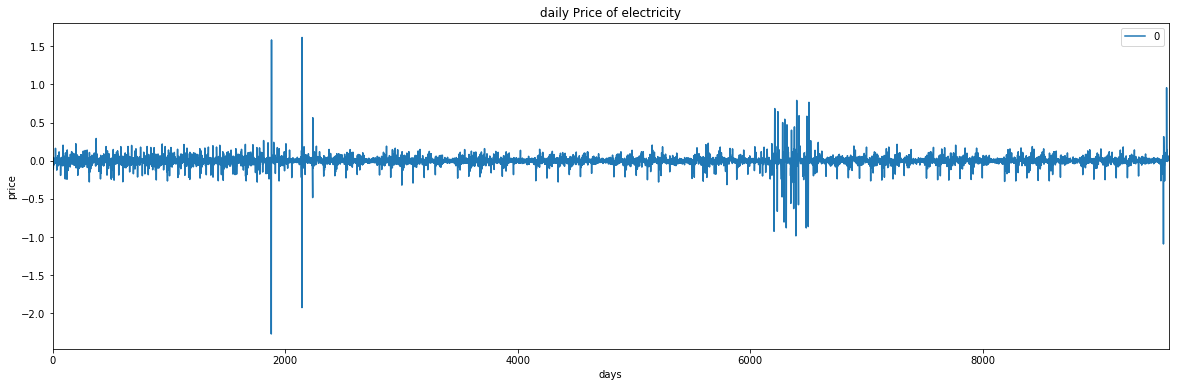

In [0]:
y.plot(figsize=(20, 6))
plt.xlabel('days')
plt.ylabel('price')
plt.title('daily Price of electricity')
plt.show()

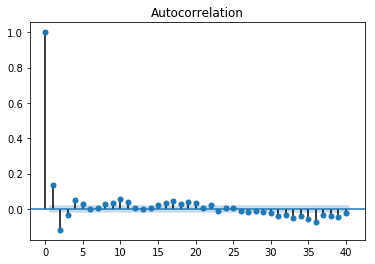

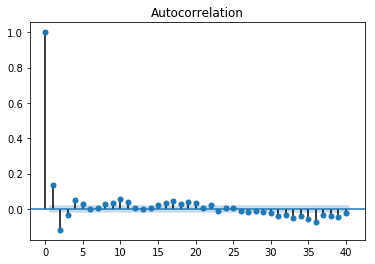

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y)

In [0]:
# Test for Stationarity

from statsmodels.tsa.stattools import adfuller
X = y.values
X = X.flatten()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.468415
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [0]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 15) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 15)
SARIMAX: (0, 0, 1) x (0, 1, 0, 15)
SARIMAX: (0, 1, 0) x (0, 1, 1, 15)
SARIMAX: (0, 1, 0) x (1, 0, 0, 15)


In [0]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 15)12 - AIC:128021.37665993022
ARIMA(0, 0, 0)x(0, 0, 1, 15)12 - AIC:116796.61574058804
ARIMA(0, 0, 0)x(0, 1, 0, 15)12 - AIC:100985.40300539703
ARIMA(0, 0, 0)x(0, 1, 1, 15)12 - AIC:99998.11475776233
ARIMA(0, 0, 0)x(1, 0, 0, 15)12 - AIC:100850.92180130104
ARIMA(0, 0, 0)x(1, 0, 1, 15)12 - AIC:99912.49909290895
ARIMA(0, 0, 0)x(1, 1, 0, 15)12 - AIC:100294.64272607278
ARIMA(0, 0, 0)x(1, 1, 1, 15)12 - AIC:98876.69713659403
ARIMA(0, 0, 1)x(0, 0, 0, 15)12 - AIC:115336.45181589195
ARIMA(0, 0, 1)x(0, 0, 1, 15)12 - AIC:105926.66874841339
ARIMA(0, 0, 1)x(0, 1, 0, 15)12 - AIC:91223.67559871914
ARIMA(0, 0, 1)x(0, 1, 1, 15)12 - AIC:90900.24402634476
ARIMA(0, 0, 1)x(1, 0, 0, 15)12 - AIC:91069.53138211492
ARIMA(0, 0, 1)x(1, 0, 1, 15)12 - AIC:90803.01238535906
ARIMA(0, 0, 1)x(1, 1, 0, 15)12 - AIC:90988.31017318627
ARIMA(0, 0, 1)x(1, 1, 1, 15)12 - AIC:88844.40213553872
ARIMA(0, 1, 0)x(0, 0, 0, 15)12 - AIC:73247.12676576411
ARIMA(0, 1, 0)x(0, 0, 1, 15)12 - AIC:73138.74627175047
ARI

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 15)12 - AIC:73112.82067192913
ARIMA(0, 1, 0)x(1, 0, 0, 15)12 - AIC:73145.92382518815
ARIMA(0, 1, 0)x(1, 0, 1, 15)12 - AIC:73138.68695960203
ARIMA(0, 1, 0)x(1, 1, 0, 15)12 - AIC:76976.270921838
ARIMA(0, 1, 0)x(1, 1, 1, 15)12 - AIC:73113.40152271677
ARIMA(0, 1, 1)x(0, 0, 0, 15)12 - AIC:73007.21031014927
ARIMA(0, 1, 1)x(0, 0, 1, 15)12 - AIC:72901.28942082163
ARIMA(0, 1, 1)x(0, 1, 0, 15)12 - AIC:79380.52166535083
ARIMA(0, 1, 1)x(0, 1, 1, 15)12 - AIC:72870.72073570774
ARIMA(0, 1, 1)x(1, 0, 0, 15)12 - AIC:72914.96991404607
ARIMA(0, 1, 1)x(1, 0, 1, 15)12 - AIC:72902.71207996104
ARIMA(0, 1, 1)x(1, 1, 0, 15)12 - AIC:76712.09057875317
ARIMA(0, 1, 1)x(1, 1, 1, 15)12 - AIC:72871.93922593212
ARIMA(1, 0, 0)x(0, 0, 0, 15)12 - AIC:73247.91441312106


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 15)12 - AIC:73142.45971258145
ARIMA(1, 0, 0)x(0, 1, 0, 15)12 - AIC:79322.33256821914
ARIMA(1, 0, 0)x(0, 1, 1, 15)12 - AIC:73020.14542666945
ARIMA(1, 0, 0)x(1, 0, 0, 15)12 - AIC:73139.50816049277
ARIMA(1, 0, 0)x(1, 0, 1, 15)12 - AIC:73139.39628480218
ARIMA(1, 0, 0)x(1, 1, 0, 15)12 - AIC:76846.06044551362
ARIMA(1, 0, 0)x(1, 1, 1, 15)12 - AIC:73019.81319423752
ARIMA(1, 0, 1)x(0, 0, 0, 15)12 - AIC:73005.14810787649
ARIMA(1, 0, 1)x(0, 0, 1, 15)12 - AIC:72898.671125831
ARIMA(1, 0, 1)x(0, 1, 0, 15)12 - AIC:79039.6332617439
ARIMA(1, 0, 1)x(0, 1, 1, 15)12 - AIC:72740.66372715181
ARIMA(1, 0, 1)x(1, 0, 0, 15)12 - AIC:72905.69692545512
ARIMA(1, 0, 1)x(1, 0, 1, 15)12 - AIC:72900.167786289
ARIMA(1, 0, 1)x(1, 1, 0, 15)12 - AIC:76530.01801933303
ARIMA(1, 0, 1)x(1, 1, 1, 15)12 - AIC:72740.87275208632
ARIMA(1, 1, 0)x(0, 0, 0, 15)12 - AIC:73072.57236439138
ARIMA(1, 1, 0)x(0, 0, 1, 15)12 - AIC:72966.33524043804
ARIMA(1, 1, 0)x(0, 1, 0, 15)12 - AIC:79441.88501655722
ARIMA(1, 1, 0)x

In [0]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9709      0.001   1042.485      0.000       0.969       0.973
ma.L1          0.1920      0.001    135.427      0.000       0.189       0.195
ar.S.L12   -3.505e-06      0.001     -0.003      0.998      -0.002       0.002
ma.S.L12      -1.0000      1.734     -0.577      0.564      -4.399       2.399
sigma2         0.0057      0.010      0.576      0.564      -0.014       0.025


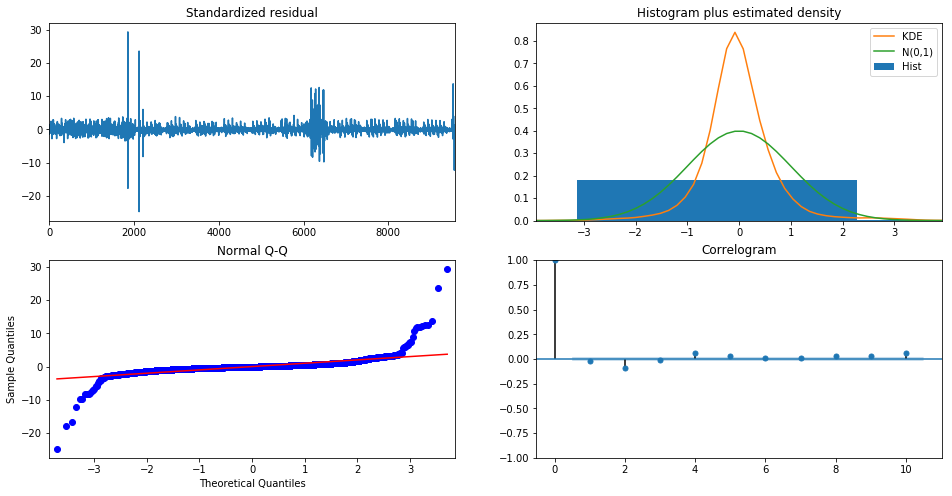

In [0]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [0]:
pred = results.predict(start=7200)

In [0]:
pred = np.array(pred)
pred.flatten().shape

(2400,)

In [0]:
#RESULTS OF ARIMA

print('r2 score=',r2_score(pred,Y_test))
print('MSE score=',mean_squared_error(pred,Y_test))
print('MAE score=',mean_absolute_error(pred,Y_test))

r2 score= 0.9796533059177293
MSE score= 0.0030286462433821728
MAE score= 0.03197152459480223


# Making Final Prediction (Combining ARIMA and EML)

In [0]:
pred2 = np.array(eml_fit2).flatten()
pred2.shape

(2400,)

In [0]:
res = (pred + pred2)/2

In [0]:
print('r2 score=',r2_score(res,Y_test))
print('MSE Error=',mean_squared_error(res,Y_test))
print('MAE Error=',mean_absolute_error(res,Y_test))

r2 score= 0.8745434893711111
MSE Error= 0.02253866818403588
MAE Error= 0.11286566370871261
